In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.cluster import KMeans
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import shap
from catboost import Pool
import subprocess
import time
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

SEED = 42


**1.DATA LOADER**

In [2]:

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

ADMISSION_PATH = '../data/admission.csv'
ACADEMIC_PATH = '../data/academic_records.csv'
TEST_PATH = '../data/test.csv'

try:
    df_admit = pd.read_csv(ADMISSION_PATH)
    df_acad = pd.read_csv(ACADEMIC_PATH)
    print(f"Loaded Admission: {df_admit.shape}")
    print(f"Loaded Academic: {df_acad.shape}")
except FileNotFoundError:
    print("File not found. Please check paths.")

Loaded Admission: (30217, 6)
Loaded Academic: (105726, 6)


**2.CLEANING DATA**

In [3]:
def clean_data(df_admit, df_acad):
    print("--- Cleaning Data (Fixed Logic) ---")

    df_acad['MA_SO_SV'] = df_acad['MA_SO_SV'].astype(str).str.strip().str.upper()
    df_admit['MA_SO_SV'] = df_admit['MA_SO_SV'].astype(str).str.strip().str.upper()

    df_acad = df_acad.reset_index(drop=True)
    initial_count = len(df_acad)
    df_acad = df_acad.drop_duplicates(subset=['MA_SO_SV', 'HOC_KY'], keep='last')
    print(f"   Removed {initial_count - len(df_acad)} duplicate records.")

    def parse_semester(s):
        try:
            parts = str(s).strip().split()
            hk_part = parts[0].upper()
            year_part = parts[1]

            if 'HE' in hk_part:
                hk_num = 3
            else:
                hk_num = int(''.join(filter(str.isdigit, hk_part)))

            year_start = int(year_part.split('-')[0])
            return hk_num, year_start
        except:
            return np.nan, np.nan

    temp = df_acad['HOC_KY'].apply(parse_semester)
    df_acad['HK_NUM'] = [x[0] for x in temp]
    df_acad['NAM_HOC'] = [x[1] for x in temp]

    df_acad = df_acad.dropna(subset=['NAM_HOC', 'HK_NUM'])
    df_acad['NAM_HOC'] = df_acad['NAM_HOC'].astype(int)
    df_acad['HK_NUM'] = df_acad['HK_NUM'].astype(int)

    df_acad['TIME_INDEX'] = df_acad['NAM_HOC'] * 10 + df_acad['HK_NUM']
    df_acad = df_acad.sort_values(by=['MA_SO_SV', 'TIME_INDEX'])

    GLOBAL_BASE_YEAR = 2015

    df_acad['REAL_TERM_INDEX'] = (df_acad['NAM_HOC'] - GLOBAL_BASE_YEAR) * 3 + df_acad['HK_NUM']

    df_acad['HOC_KY_INDEX'] = df_acad.groupby('MA_SO_SV').cumcount() + 1

    cols_credit = ['TC_DANGKY', 'TC_HOANTHANH']
    for c in cols_credit:
        if c in df_acad.columns:
            df_acad[c] = df_acad[c].fillna(0).clip(lower=0)

    cols_score = ['GPA', 'CPA']
    for c in cols_score:
        if c in df_acad.columns:
            df_acad[c] = df_acad[c].clip(0, 4.0)

    mask_wrong = df_acad['TC_HOANTHANH'] > df_acad['TC_DANGKY']
    if mask_wrong.sum() > 0:
        print(f"Fixed {mask_wrong.sum()} rows where TC_HOANTHANH > TC_DANGKY.")
        df_acad.loc[mask_wrong, 'TC_HOANTHANH'] = df_acad.loc[mask_wrong, 'TC_DANGKY']

    return df_admit, df_acad

df_admit_clean, df_acad_clean = clean_data(df_admit.copy(), df_acad.copy())

--- Cleaning Data (Fixed Logic) ---
   Removed 460 duplicate records.


**3.FEATURE EGINEERING**


In [4]:
def generate_features_unified(df_admit, df_acad, saved_kmeans=None):
    print("--- STARTING UNIFIED FEATURE ENGINEERING (FIXED RANKING CONTEXT) ---")

    print("Pre-calculating Global Admission Ranks...")
    df_admit_full = df_admit.copy()
    rank_grp = df_admit_full.groupby(['NAM_TUYENSINH', 'PTXT'])
    df_admit_full['ADMISSION_RANK_PCT'] = rank_grp['DIEM_TRUNGTUYEN'].transform(lambda x: x.rank(pct=True))
    df_admit_full['ADMISSION_PROXY_GPA'] = 1.5 + (df_admit_full['ADMISSION_RANK_PCT'] * 2.5)
    df_admit_full['ADMISSION_ZSCORE'] = rank_grp['DIEM_TRUNGTUYEN'].transform(
        lambda x: (x - x.mean()) / (x.std() + 0.1)
    ).fillna(0)

    max_score_internal = rank_grp['DIEM_TRUNGTUYEN'].transform('max')
    df_admit_full['ADMISSION_SCORE_NORM'] = df_admit_full['DIEM_TRUNGTUYEN'] / (max_score_internal + 0.1)

    df = df_acad.merge(df_admit_full, on='MA_SO_SV', how='left')
    df = df.sort_values(by=['MA_SO_SV', 'TIME_INDEX']).reset_index(drop=True)
    print("⏳ Handling Time Gaps & Interruptions...")

    df['PREV_TERM_INDEX'] = df.groupby('MA_SO_SV')['REAL_TERM_INDEX'].shift(1)
    df['TIME_GAP'] = (df['REAL_TERM_INDEX'] - df['PREV_TERM_INDEX']).fillna(1)

    df['IS_INTERRUPTED'] = (df['TIME_GAP'] > 1).astype(int)
    df['MISSED_TERMS'] = (df['TIME_GAP'] - 1).clip(lower=0)

    def robust_encoder(col):
        if col.dtype == 'object':
            top_cats = col.value_counts().nlargest(20).index.tolist()
            return col.apply(lambda x: x if x in top_cats else 'OTHER')
        return col

    if 'PTXT' in df.columns: df['PTXT'] = robust_encoder(df['PTXT'])
    if 'TOHOP_XT' in df.columns: df['TOHOP_XT'] = robust_encoder(df['TOHOP_XT'])

    df['TERM_RATE'] = (df['TC_HOANTHANH'] / df['TC_DANGKY']).fillna(0)
    df['FAIL_CREDITS_TERM'] = (df['TC_DANGKY'] - df['TC_HOANTHANH']).clip(lower=0)
    grp = df.groupby('MA_SO_SV')

    df['GPA_LAG1'] = grp['GPA'].shift(1)
    df['RATE_LAG1'] = grp['TERM_RATE'].shift(1)
    df['FAIL_LAG1'] = grp['FAIL_CREDITS_TERM'].shift(1)
    df['CREDITS_LAG1'] = grp['TC_HOANTHANH'].shift(1)
    df['GPA_LAG2'] = grp['GPA'].shift(2)
    df['CPA_LAG1'] = grp['CPA'].shift(1).fillna(2.5)

    df['GPA_LAG1'] = df['GPA_LAG1'].fillna(df['ADMISSION_PROXY_GPA']).fillna(2.5)
    df['RATE_LAG1'] = df['RATE_LAG1'].fillna(0.95)
    df['FAIL_LAG1'] = df['FAIL_LAG1'].fillna(0)
    df['CREDITS_LAG1'] = df['CREDITS_LAG1'].fillna(0)

    df['GAP_LAG1'] = df['GPA_LAG1'] - df['CPA_LAG1']

    decay_factor = df['TIME_GAP'] ** 0.5
    df['GPA_LAG1_DECAY'] = df['GPA_LAG1'] / decay_factor
    df['RATE_LAG1_DECAY'] = df['RATE_LAG1'] / decay_factor
    df['COMEBACK_RISK'] = df['TC_DANGKY'] * df['MISSED_TERMS']

    df['AVG_GPA_HIST'] = df.groupby('MA_SO_SV')['GPA_LAG1'].transform(lambda x: x.expanding().mean())
    df['AVG_RATE_HIST'] = df.groupby('MA_SO_SV')['RATE_LAG1'].transform(lambda x: x.expanding().mean())
    df['TOTAL_FAIL_CREDITS'] = df.groupby('MA_SO_SV')['FAIL_LAG1'].transform(lambda x: x.expanding().sum())
    df['EMA_GPA_RECENT'] = df.groupby('MA_SO_SV')['GPA_LAG1'].transform(lambda x: x.ewm(span=3).mean())
    df['EMA_CPA_RECENT'] = df.groupby('MA_SO_SV')['CPA_LAG1'].transform(lambda x: x.ewm(span=3).mean())
    df['EMA_RATE_RECENT'] = df.groupby('MA_SO_SV')['RATE_LAG1'].transform(lambda x: x.ewm(span=3).mean())
    df['GPA_STD'] = df.groupby('MA_SO_SV')['GPA_LAG1'].transform(lambda x: x.expanding().std()).fillna(0.5)
    df['GPA_ZSCORE'] = (df['GPA_LAG1'] - df['AVG_GPA_HIST']) / (df['GPA_STD'] + 0.1)

    cohort_grp = df.groupby(['NAM_TUYENSINH', 'TIME_INDEX'])
    df['COHORT_AVG_GPA'] = cohort_grp['GPA_LAG1'].transform('mean')
    df['GPA_VS_COHORT'] = df['GPA_LAG1'] - df['COHORT_AVG_GPA']
    df['COHORT_RANK'] = cohort_grp['GPA_LAG1'].transform(lambda x: x.rank(pct=True))
    df['GPA_VOLATILITY'] = (df['GPA_LAG1'] - df['GPA_LAG2']).abs().fillna(0)
    df['IS_FRESHMAN'] = (df['HOC_KY_INDEX'] == 1).astype(int)
    df['IS_HK1'] = (df['HK_NUM'] == 1).astype(int)
    df['IS_HK2'] = (df['HK_NUM'] == 2).astype(int)
    df['IS_SUMMER'] = (df['HK_NUM'] == 3).astype(int)
    df['YEARS_IN_SCHOOL'] = df['NAM_HOC'] - df['NAM_TUYENSINH']

    df['LOAD_RATIO'] = df['TC_DANGKY'] / (df['EMA_GPA_RECENT'] + 0.1)
    df['EXPECTED_YIELD'] = df['TC_DANGKY'] * df['EMA_RATE_RECENT']
    df['RISK_FACTOR'] = df['TC_DANGKY'] / (df['GPA_LAG1'] + 0.1)
    df['CREDIT_VELOCITY'] = df.groupby('MA_SO_SV')['CREDITS_LAG1'].transform(lambda x: x.expanding().sum()) / (df['YEARS_IN_SCHOOL'] + 0.5)
    df['PRESSURE_INDEX'] = df['YEARS_IN_SCHOOL'] / (df['CPA_LAG1'] + 0.1)
    print("Processing Student Clusters...")

    cluster_cols = ['AVG_GPA_HIST', 'AVG_RATE_HIST', 'TOTAL_FAIL_CREDITS', 'CPA_LAG1']
    X_cluster = df[cluster_cols].fillna(0)

    if saved_kmeans is None:
        print("   Create & Fit NEW KMeans model...")
        kmeans = KMeans(n_clusters=5, random_state=SEED, n_init=10)
        df['STUDENT_CLUSTER'] = kmeans.fit_predict(X_cluster)
        saved_kmeans = kmeans
    else:
        print("   Using SAVED KMeans model to predict...")
        df['STUDENT_CLUSTER'] = saved_kmeans.predict(X_cluster)


    macro_master = {
        2015: {'Candidates': 1005654, 'COVID': 0.0},
        2016: {'Candidates': 887396,  'COVID': 0.0},
        2017: { 'Candidates': 866002,  'COVID': 0.0},
        2018: { 'Candidates': 925792,  'COVID': 0.0},
        2019: {'Candidates': 887104,  'COVID': 0},
        2020: { 'Candidates': 900079,  'COVID': 0.5},
        2021: { 'Candidates': 1021340, 'COVID': 2.0},
        2022: { 'Candidates': 1002432, 'COVID': 0.0},
        2023: {'Candidates': 1024063, 'COVID': 0.0},
        2024: { 'Candidates': 1071000, 'COVID': 0.0},
        2025: {'Candidates': 1100000, 'COVID': 0.0}
    }

    def get_macro_data(year, key):
        return macro_master.get(year, { 'Candidates': 900000, 'COVID': 0.0}).get(key)

    df['COHORT_COMPETITIVENESS'] = df['NAM_TUYENSINH'].apply(lambda x: get_macro_data(x, 'Candidates')) / 1000000.0
    target_year_col = 'NAM_HOC' if 'NAM_HOC' in df.columns else 'NAM_TUYENSINH'
    df['COVID_INTENSITY'] = df[target_year_col].apply(lambda x: get_macro_data(x, 'COVID'))

    cols_to_fill_zero = [
        'GPA_LAG2', 'GPA_ZSCORE', 'IS_INTERRUPTED',
        'GPA_VS_COHORT', 'COHORT_RANK',
        'CREDIT_VELOCITY', 'GPA_VOLATILITY', 'PRESSURE_INDEX'
    ]

    existing_cols = [c for c in cols_to_fill_zero if c in df.columns]
    df[existing_cols] = df[existing_cols].fillna(0)
    df = df.replace([np.inf, -np.inf], -1)

    print("Feature Engineering (Fixed Context) Completed.")
    return df,saved_kmeans

print("⏳ Đang chạy Feature Engineering...")
df_final, kmeans_model = generate_features_unified(df_admit_clean, df_acad_clean)

cols_to_exclude = [
    'MA_SO_SV', 'HOC_KY', 'NAM_HOC', 'NAM_TUYENSINH', 'TIME_INDEX',
    'Tên trường', 'Ý nghĩa', 'PTXT', 'TOHOP_XT', 'MAJOR_GROUP',
    'TC_HOANTHANH', 'GPA', 'CPA',
    'TERM_RATE', 'FAIL_CREDITS_TERM', 'FAIL_CREDITS',
    'DIEM_TRUNGTUYEN', 'DIEM_CHUAN',

    'SCORE_GAP',
    'REAL_ABILITY_SCORE',
    'SCORE_POSITION_INDEX',
    'SCORE_RATIO_NATIONAL',
    'sample_weight', 'final_weight'
]

X_temp = df_final.drop(columns=cols_to_exclude, errors='ignore').select_dtypes(include=[np.number])
features_list = X_temp.columns.tolist()

print(f"Selected {len(features_list)} features for Training.")
print(features_list)
display(df_final[features_list].head())

⏳ Đang chạy Feature Engineering...
--- STARTING UNIFIED FEATURE ENGINEERING (FIXED RANKING CONTEXT) ---
Pre-calculating Global Admission Ranks...
⏳ Handling Time Gaps & Interruptions...
Processing Student Clusters...
   Create & Fit NEW KMeans model...
Feature Engineering (Fixed Context) Completed.
Selected 47 features for Training.
['TC_DANGKY', 'HK_NUM', 'REAL_TERM_INDEX', 'HOC_KY_INDEX', 'ADMISSION_RANK_PCT', 'ADMISSION_PROXY_GPA', 'ADMISSION_ZSCORE', 'ADMISSION_SCORE_NORM', 'PREV_TERM_INDEX', 'TIME_GAP', 'IS_INTERRUPTED', 'MISSED_TERMS', 'GPA_LAG1', 'RATE_LAG1', 'FAIL_LAG1', 'CREDITS_LAG1', 'GPA_LAG2', 'CPA_LAG1', 'GAP_LAG1', 'GPA_LAG1_DECAY', 'RATE_LAG1_DECAY', 'COMEBACK_RISK', 'AVG_GPA_HIST', 'AVG_RATE_HIST', 'TOTAL_FAIL_CREDITS', 'EMA_GPA_RECENT', 'EMA_CPA_RECENT', 'EMA_RATE_RECENT', 'GPA_STD', 'GPA_ZSCORE', 'COHORT_AVG_GPA', 'GPA_VS_COHORT', 'COHORT_RANK', 'GPA_VOLATILITY', 'IS_FRESHMAN', 'IS_HK1', 'IS_HK2', 'IS_SUMMER', 'YEARS_IN_SCHOOL', 'LOAD_RATIO', 'EXPECTED_YIELD', 'RISK_

,TC_DANGKY,HK_NUM,REAL_TERM_INDEX,HOC_KY_INDEX,ADMISSION_RANK_PCT,ADMISSION_PROXY_GPA,ADMISSION_ZSCORE,ADMISSION_SCORE_NORM,PREV_TERM_INDEX,TIME_GAP,IS_INTERRUPTED,MISSED_TERMS,GPA_LAG1,RATE_LAG1,FAIL_LAG1,CREDITS_LAG1,GPA_LAG2,CPA_LAG1,GAP_LAG1,GPA_LAG1_DECAY,RATE_LAG1_DECAY,COMEBACK_RISK,AVG_GPA_HIST,AVG_RATE_HIST,TOTAL_FAIL_CREDITS,EMA_GPA_RECENT,EMA_CPA_RECENT,EMA_RATE_RECENT,GPA_STD,GPA_ZSCORE,COHORT_AVG_GPA,GPA_VS_COHORT,COHORT_RANK,GPA_VOLATILITY,IS_FRESHMAN,IS_HK1,IS_HK2,IS_SUMMER,YEARS_IN_SCHOOL,LOAD_RATIO,EXPECTED_YIELD,RISK_FACTOR,CREDIT_VELOCITY,PRESSURE_INDEX,STUDENT_CLUSTER,COHORT_COMPETITIVENESS,COVID_INTENSITY
0,18,1,25,1,0.259793,2.149482,-0.563901,0.784112,NaN,1.0,0,0.0,2.149482,0.950000,0.0,0.0,0.00,2.50,-0.350518,2.149482,0.950000,0.0,2.149482,0.950000,0.0,2.149482,2.500000,0.950000,0.500000,0.000000,2.752424,-0.602941,0.259183,0.00,1,1,0,0,0,8.001841,17.100000,8.001841,0.000000,0.000000,0,1.024063,0.0
1,18,2,26,2,0.259793,2.149482,-0.563901,0.784112,25.0,1.0,0,0.0,1.970000,0.833333,3.0,15.0,0.00,1.64,0.330000,1.970000,0.833333,0.0,2.059741,0.891667,3.0,2.029827,1.926667,0.872222,0.126913,-0.395487,2.290987,-0.320987,0.323059,0.00,0,0,1,0,0,8.451389,15.700000,8.695652,30.000000,0.000000,0,1.024063,0.0
2,9,1,19,1,0.452781,2.631952,0.079311,0.795728,NaN,1.0,0,0.0,2.631952,0.950000,0.0,0.0,0.00,2.50,0.131952,2.631952,0.950000,0.0,2.631952,0.950000,0.0,2.631952,2.500000,0.950000,0.500000,0.000000,2.751636,-0.119684,0.452381,0.00,1,1,0,0,0,3.294348,8.550000,3.294348,0.000000,0.000000,0,1.021340,2.0
3,19,2,20,2,0.452781,2.631952,0.079311,0.795728,19.0,1.0,0,0.0,3.850000,1.000000,0.0,9.0,0.00,3.85,0.000000,3.850000,1.000000,0.0,3.240976,0.975000,0.0,3.443984,3.400000,0.983333,0.861290,0.633549,2.541968,1.308032,0.976387,0.00,0,0,1,0,0,5.361198,18.683333,4.810127,18.000000,0.000000,0,1.021340,2.0
4,21,1,22,3,0.452781,2.631952,0.079311,0.795728,20.0,2.0,1,1.0,3.120000,1.000000,0.0,19.0,3.85,2.77,0.350000,2.206173,0.707107,21.0,3.200651,0.983333,0.0,3.258850,3.040000,0.992857,0.613016,-0.113112,2.367217,0.752783,0.944194,0.73,0,1,0,0,1,6.252139,20.850000,6.521739,18.666667,0.348432,0,1.021340,0.0


**4.Training**


TRAINING PIPELINE
Running Feature Engineering...
--- STARTING UNIFIED FEATURE ENGINEERING (FIXED RANKING CONTEXT) ---
Pre-calculating Global Admission Ranks...
⏳ Handling Time Gaps & Interruptions...
Processing Student Clusters...
   Create & Fit NEW KMeans model...
Feature Engineering (Fixed Context) Completed.
Feature Engineering Done. KMeans model captured.
 Creating Smart Weights...
 Train set: (90122, 45) observations
 Valid set: (15144, 45) observations

 --- STEP 2: FEATURE ENGINEERING AUDIT ---
     Dropping 3 highly collinear features.
     Removing 3 useless features.
['ADMISSION_PROXY_GPA', 'MISSED_TERMS', 'IS_HK2', 'IS_INTERRUPTED', 'IS_FRESHMAN', 'IS_SUMMER']
 FINAL FEATURE LIST (39 features)

 --- STEP 3: TRAINING MODELS ---
   1. LightGBM training...
      -> Best Iteration: 505
   2. XGBoost training...
      -> Best Iteration: 830
   3. CatBoost training...
      -> Best Iteration: 1723

 --- STEP 4: PRECISE ENSEMBLE OPTIMIZATION (SLSQP) ---
    Model Correlation Matr

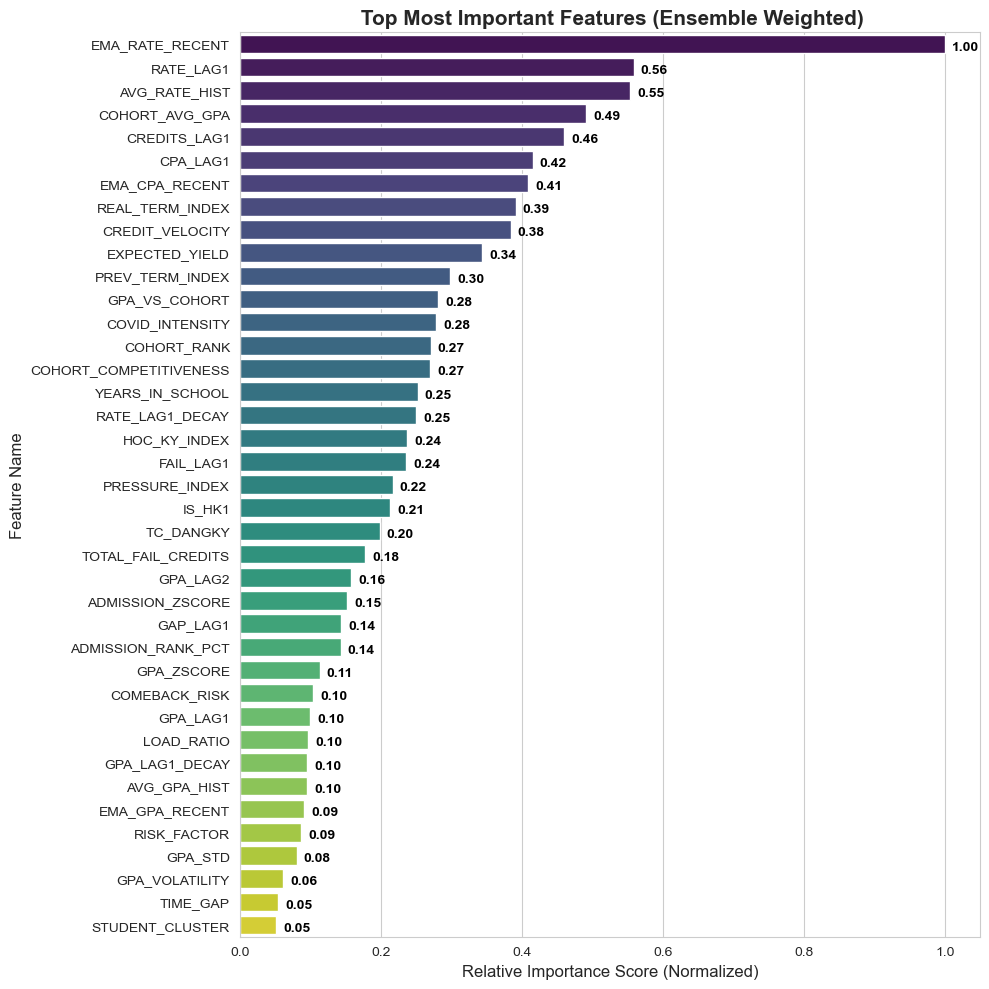


TRAINING COMPLETE! READY FOR SUBMISSION.


In [5]:


warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("TRAINING PIPELINE")
print("="*60)

print("Running Feature Engineering...")

df_final, kmeans_model = generate_features_unified(df_admit_clean, df_acad_clean, saved_kmeans=None)
print("Feature Engineering Done. KMeans model captured.")

INDEX_TRAIN_END = 20231
INDEX_VALID = 20232

COLS_TO_DROP = [
    'MA_SO_SV', 'HOC_KY', 'Tên trường', 'Ý nghĩa', 'PTXT', 'TOHOP_XT', 'MAJOR_GROUP',
    'NAM_HOC', 'NAM_TUYENSINH', 'TIME_INDEX', 'HK_NUM',
    'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'ADMISSION_SCORE_NORM',
    'SCORE_GAP', 'REAL_ABILITY_SCORE', 'SCORE_POSITION_INDEX', 'SCORE_RATIO_NATIONAL',
    'TC_HOANTHANH', 'GPA', 'CPA',
    'TERM_RATE', 'FAIL_CREDITS_TERM', 'FAIL_CREDITS',
    'GPA_SHIFTED', 'RATE_SHIFTED', 'FAIL_SHIFTED', 'DIEM_RL',
    'sample_weight', 'final_weight', 'SMART_CUTOFF'
]

df_learning = df_final[df_final['TIME_INDEX'] <= INDEX_VALID].copy()

print(" Creating Smart Weights...")
base_time_weight = df_learning['REAL_TERM_INDEX'] - df_learning['REAL_TERM_INDEX'].min()
time_decay = np.exp(base_time_weight * 0.05)
credit_weight = df_learning['TC_DANGKY'].replace(0, 0.5)
df_learning['final_weight'] = time_decay * credit_weight

X_all = df_learning.drop(columns=COLS_TO_DROP, errors='ignore').select_dtypes(include=[np.number])
y_all = (df_learning['TC_HOANTHANH'] / df_learning['TC_DANGKY']).fillna(0).clip(0, 1)
w_all = df_learning['final_weight']

mask_train = df_learning['TIME_INDEX'] <= INDEX_TRAIN_END
mask_valid = df_learning['TIME_INDEX'] == INDEX_VALID

X_train, y_train, w_train = X_all[mask_train], y_all[mask_train], w_all[mask_train]
X_valid, y_valid, w_valid = X_all[mask_valid], y_all[mask_valid], w_all[mask_valid]

train_active = df_learning.loc[mask_train, 'TC_DANGKY'] > 0
valid_active = df_learning.loc[mask_valid, 'TC_DANGKY'] > 0

X_train, y_train, w_train = X_train[train_active], y_train[train_active], w_train[train_active]
X_valid, y_valid, w_valid = X_valid[valid_active], y_valid[valid_active], w_valid[valid_active]

print(f" Train set: {X_train.shape} observations")
print(f" Valid set: {X_valid.shape} observations")

print("\n --- STEP 2: FEATURE ENGINEERING AUDIT ---")

corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_collinear = [column for column in upper.columns if any(upper[column] > 0.98)]
if to_drop_collinear:
    print(f"     Dropping {len(to_drop_collinear)} highly collinear features.")
    X_train = X_train.drop(columns=to_drop_collinear)
    X_valid = X_valid.drop(columns=to_drop_collinear)

selector = CatBoostRegressor(iterations=100, verbose=0, random_seed=SEED)
selector.fit(X_train, y_train, sample_weight=w_train)
imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gain': selector.feature_importances_})
zero_gain_feats = imp_df[imp_df['Gain'] == 0]['Feature'].tolist()
if zero_gain_feats:
    print(f"     Removing {len(zero_gain_feats)} useless features.")
    X_train = X_train.drop(columns=zero_gain_feats)
    X_valid = X_valid.drop(columns=zero_gain_feats)

print(to_drop_collinear + zero_gain_feats)
final_features = X_train.columns.tolist()
print(f" FINAL FEATURE LIST ({len(final_features)} features)")

print("\n --- STEP 3: TRAINING MODELS ---")
common_params = {'random_state': SEED, 'n_jobs': -1}

print("   1. LightGBM training...")
lgb_params = {
    **common_params,
    'objective': 'regression', 'metric': 'rmse',
    'n_estimators': 5000, 'learning_rate': 0.015,
    'num_leaves': 31, 'max_depth': 8,
    'subsample': 0.8, 'colsample_bytree': 0.7,
    'min_child_samples': 50,
    'verbose': -1
}
model_lgb = lgb.LGBMRegressor(**lgb_params)
model_lgb.fit(
    X_train, y_train, sample_weight=w_train,
    eval_set=[(X_valid, y_valid)], eval_metric='rmse',
    callbacks=[lgb.early_stopping(150, verbose=False)]
)
print(f"      -> Best Iteration: {model_lgb.best_iteration_}")

print("   2. XGBoost training...")
xgb_params = {
    **common_params,
    'n_estimators': 5000, 'learning_rate': 0.015,
    'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.7,
    'objective': 'reg:squarederror', 'tree_method': 'hist',
    'eval_metric': 'rmse', 'early_stopping_rounds': 150,
    'min_child_weight': 5
}
model_xgb = xgb.XGBRegressor(**xgb_params)
model_xgb.fit(
    X_train, y_train, sample_weight=w_train,
    eval_set=[(X_valid, y_valid)], verbose=False
)
print(f"      -> Best Iteration: {model_xgb.best_iteration}")

print("   3. CatBoost training...")
cb_params = {
    'random_seed': SEED, 'verbose': 0, 'allow_writing_files': False,
    'iterations': 5000, 'learning_rate': 0.015,
    'depth': 7, 'loss_function': 'RMSE', 'eval_metric': 'RMSE',
    'early_stopping_rounds': 150,
    'subsample': 0.8, 'colsample_bylevel': 0.7
}
model_cb = CatBoostRegressor(**cb_params)
model_cb.fit(X_train, y_train, sample_weight=w_train, eval_set=(X_valid, y_valid))
print(f"      -> Best Iteration: {model_cb.get_best_iteration()}")

print("\n --- STEP 4: PRECISE ENSEMBLE OPTIMIZATION (SLSQP) ---")

p_lgb = model_lgb.predict(X_valid).clip(0, 1)
p_xgb = model_xgb.predict(X_valid).clip(0, 1)
p_cb = model_cb.predict(X_valid).clip(0, 1)

tc_valid_vals = df_learning.loc[y_valid.index, 'TC_DANGKY'].values
y_valid_credits = y_valid.values * tc_valid_vals

ensemble_df = pd.DataFrame({
    'LGB': p_lgb,
    'XGB': p_xgb,
    'CatBoost': p_cb
})
corr_matrix = ensemble_df.corr()

print("    Model Correlation Matrix (Lower is better for Ensemble):")
print(corr_matrix)

if corr_matrix.min().min() > 0.98:
    print("    WARNING: Models are highly correlated. Improvement might be small.")
else:
    print("    Models are diverse. Ensemble should work well!")

def ensemble_loss_function(weights):
    blend_rate = (p_lgb * weights[0] + p_xgb * weights[1] + p_cb  * weights[2])
    blend_credit = blend_rate * tc_valid_vals

    return np.sqrt(mean_squared_error(y_valid_credits, blend_credit))

constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
bounds = [(0, 1)] * 3
initial_guess = [0.33, 0.33, 0.34]

print("   ⏳ Optimizing weights using SciPy SLSQP...")
result = minimize(
    ensemble_loss_function,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    tol=1e-6
)

best_w = result.x
best_rmse = result.fun

print("-" * 40)
print(f" OPTIMIZED WEIGHTS FOUND:")
print(f"   🔹 LightGBM : {best_w[0]:.4f}")
print(f"   🔹 XGBoost  : {best_w[1]:.4f}")
print(f"   🔹 CatBoost : {best_w[2]:.4f}")
print("-" * 40)
print(f" Final Ensemble RMSE (Valid): {best_rmse:.5f}")

single_scores = {
    'LGB': np.sqrt(mean_squared_error(y_valid_credits, p_lgb * tc_valid_vals)),
    'XGB': np.sqrt(mean_squared_error(y_valid_credits, p_xgb * tc_valid_vals)),
    'CB':  np.sqrt(mean_squared_error(y_valid_credits, p_cb * tc_valid_vals))
}
best_single = min(single_scores.values())
improvement = best_single - best_rmse
print(f" Improvement over best single model: {improvement:.5f} RMSE")

print("\n--- STEP 5: FULL RETRAINING & EXPORT ---")
X_full = pd.concat([X_train, X_valid])
y_full = pd.concat([y_train, y_valid])
w_full = pd.concat([w_train, w_valid])

final_lgb = lgb.LGBMRegressor(**{**lgb_params, 'n_estimators': int(model_lgb.best_iteration_ * 1.15)})
final_lgb.fit(X_full, y_full, sample_weight=w_full)

xgb_params_full = xgb_params.copy()
xgb_params_full.pop('early_stopping_rounds', None)
xgb_params_full['n_estimators'] = int(model_xgb.best_iteration * 1.15)
final_xgb = xgb.XGBRegressor(**xgb_params_full)
final_xgb.fit(X_full, y_full, sample_weight=w_full)

cb_params_full = cb_params.copy()
cb_params_full.pop('early_stopping_rounds', None)
cb_params_full['iterations'] = int(model_cb.get_best_iteration() * 1.15)
final_cb = CatBoostRegressor(**cb_params_full)
final_cb.fit(X_full, y_full, sample_weight=w_full)

model_package = {
    'lgb': final_lgb,
    'xgb': final_xgb,
    'cb': final_cb,
    'weights': best_w,
    'features': final_features,
    'best_rmse': best_rmse,
    'kmeans_feature_model': kmeans_model
}

joblib.dump(model_package, '../model/ensemble_models_grandmaster.pkl')
print(f"Model saved to 'ensemble_models_grandmaster.pkl' (Robust & Safe)")

print("\n--- STEP 6: ENSEMBLE FEATURE IMPORTANCE ANALYSIS ---")

def get_normalized_importance(model, model_type, feature_names):
    if model_type == 'lgb':
        imp = model.booster_.feature_importance(importance_type='gain')
    elif model_type == 'xgb':
        imp = model.feature_importances_
    elif model_type == 'cb':
        imp = model.get_feature_importance()
    if imp.max() > 0:
        return imp / imp.max()
    return imp

fi_df = pd.DataFrame({'Feature': final_features})
fi_df['LGB_Imp'] = get_normalized_importance(final_lgb, 'lgb', final_features)
fi_df['XGB_Imp'] = get_normalized_importance(final_xgb, 'xgb', final_features)
fi_df['CB_Imp']  = get_normalized_importance(final_cb, 'cb', final_features)

fi_df['Ensemble_Imp'] = (
    fi_df['LGB_Imp'] * best_w[0] +
    fi_df['XGB_Imp'] * best_w[1] +
    fi_df['CB_Imp']  * best_w[2]
)

fi_df = fi_df.sort_values(by='Ensemble_Imp', ascending=False)

plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = sns.barplot(data=fi_df, x='Ensemble_Imp', y='Feature', palette='viridis')
plt.title(' Top Most Important Features (Ensemble Weighted)', fontsize=15, fontweight='bold')
plt.xlabel('Relative Importance Score (Normalized)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

for i, v in enumerate(fi_df['Ensemble_Imp']):
    ax.text(v + 0.01, i + 0.25, f"{v:.2f}", color='black', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTRAINING COMPLETE! READY FOR SUBMISSION.")

**5.USING SHAP TO EXPLAIN AND PREPARE FOR DASHBOARD DATA**


SHAP ANALYSIS: CONVERT RATE -> CREDITS (NATIVE)
Đang tính toán SHAP values bằng CatBoost Engine...
Đang quy đổi từ Tỷ lệ (%) sang Số tín chỉ...
Đã tính xong SHAP values (Đơn vị: Tín chỉ).


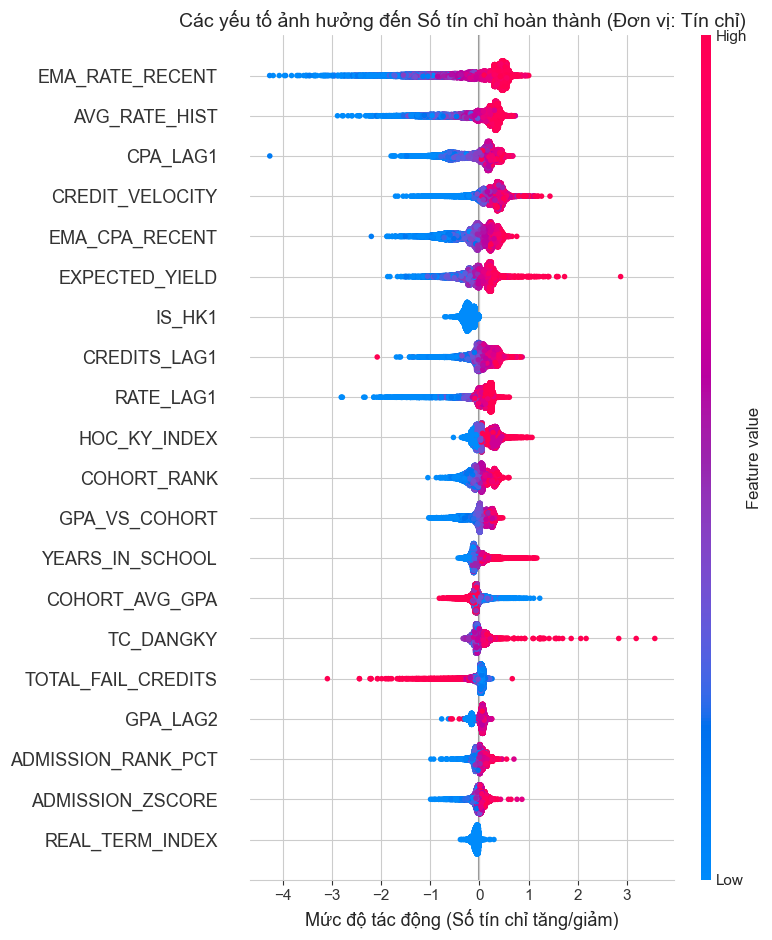


Ví dụ giải thích cho sinh viên: 00003E092652 (Đăng ký: 18 tín)


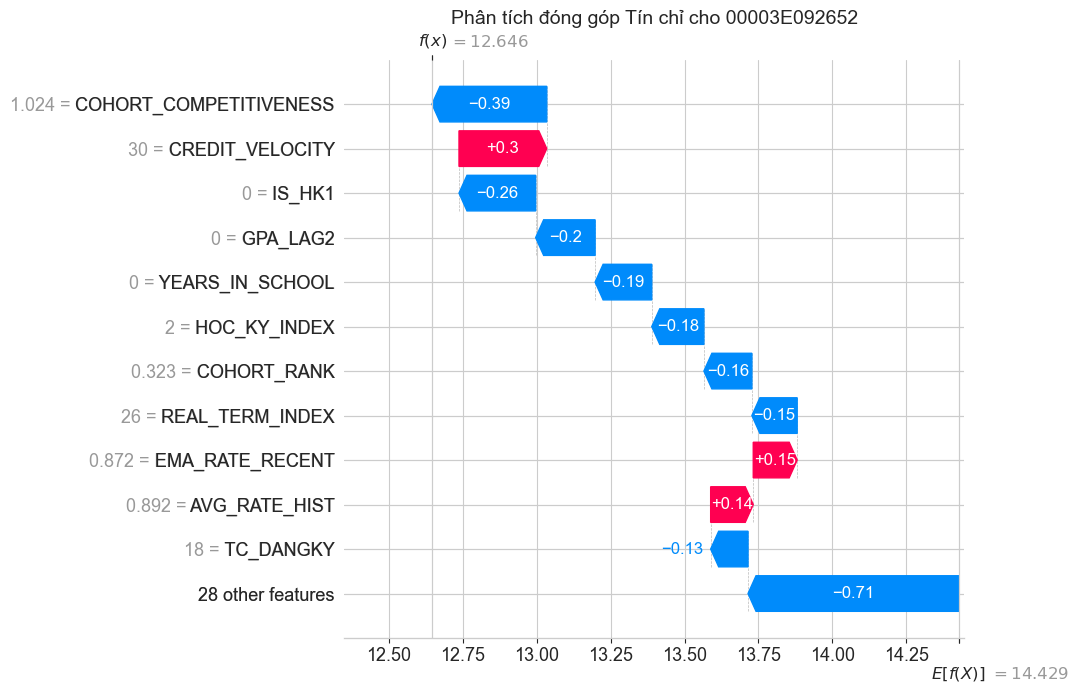


Đóng gói dữ liệu cho Dashboard...
Đã lưu file '../dashboard/dashboard_data.pkl'.


In [6]:
import shap
from catboost import Pool

print("\n" + "="*60)
print("SHAP ANALYSIS: CONVERT RATE -> CREDITS (NATIVE)")
print("="*60)

if isinstance(model_package, dict):
    actual_model = model_package['cb']
else:
    actual_model = model_package

tc_dangky_vec = df_learning.loc[X_valid.index, 'TC_DANGKY'].values
tc_dangky_vec = tc_dangky_vec.reshape(-1, 1)

print("Đang tính toán SHAP values bằng CatBoost Engine...")

shap_pool = Pool(X_valid, y_valid)
shap_values_raw = actual_model.get_feature_importance(shap_pool, type='ShapValues')

shap_values_rate = shap_values_raw[:, :-1]
base_values_rate = shap_values_raw[:, -1]

print("Đang quy đổi từ Tỷ lệ (%) sang Số tín chỉ...")

shap_values_credits = shap_values_rate * tc_dangky_vec

base_values_credits = base_values_rate * tc_dangky_vec.flatten()

shap_explanation_credits = shap.Explanation(
    values=shap_values_credits,
    base_values=base_values_credits,
    data=X_valid,
    feature_names=X_valid.columns.tolist()
)

print("Đã tính xong SHAP values (Đơn vị: Tín chỉ).")

plt.figure(figsize=(12, 8))
plt.title("Các yếu tố ảnh hưởng đến Số tín chỉ hoàn thành (Đơn vị: Tín chỉ)", fontsize=14)
shap.summary_plot(shap_explanation_credits, X_valid, show=False)
plt.xlabel("Mức độ tác động (Số tín chỉ tăng/giảm)")
plt.tight_layout()
plt.show()

sample_idx = 0
sample_id = df_learning.loc[X_valid.index[sample_idx], 'MA_SO_SV']
student_credits = df_learning.loc[X_valid.index[sample_idx], 'TC_DANGKY']

print(f"\nVí dụ giải thích cho sinh viên: {sample_id} (Đăng ký: {student_credits} tín)")

plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap_explanation_credits[sample_idx], show=False, max_display=12)
plt.title(f"Phân tích đóng góp Tín chỉ cho {sample_id}", fontsize=14)
plt.show()

print("\nĐóng gói dữ liệu cho Dashboard...")

dashboard_data = {
    'X_valid': X_valid,
    'y_valid': y_valid,
    'tc_dangky': df_learning.loc[X_valid.index, 'TC_DANGKY'].values,
    'shap_values': shap_explanation_credits,
    'student_ids': df_learning.loc[X_valid.index, 'MA_SO_SV'].values,
    'model': actual_model,
    'features': X_valid.columns.tolist()
}

joblib.dump(dashboard_data, '../dashboard/dashboard_data.pkl')
print("Đã lưu file '../dashboard/dashboard_data.pkl'.")

**6.INFERENCE**

In [7]:

warnings.filterwarnings('ignore')


MODEL_PATH = '../model/ensemble_models_grandmaster.pkl'
SUBMISSION_FILE = '../result/submission_final.csv'

print("\n" + "="*60)
print("FINAL SUBMISSION PIPELINE (FIXED & OPTIMIZED)")
print("="*60)

print("Loading Pre-trained Models...")
try:
    model_package = joblib.load(MODEL_PATH)
    final_lgb = model_package['lgb']
    final_xgb = model_package['xgb']
    final_cb = model_package['cb']
    best_weights = model_package['weights']
    train_features = model_package['features']

    # Lấy saved_kmeans ra để dùng cho Feature Engineering
    saved_kmeans = model_package.get('kmeans_feature_model')

    print(f"   - Loaded weights: {best_weights}")
    if saved_kmeans:
        print("   - Loaded saved KMeans model (Cluster Freeze).")
    else:
        print("WARNING: No saved KMeans found. Features might drift!")

except FileNotFoundError:
    raise FileNotFoundError(f"Không tìm thấy file {MODEL_PATH}. Hãy chạy train trước!")

print("Loading data...")
df_history = pd.read_csv(ACADEMIC_PATH)
df_test_original = pd.read_csv(TEST_PATH)
df_admit_raw = pd.read_csv(ADMISSION_PATH)

df_history = df_history.loc[:, ~df_history.columns.duplicated()]
df_test_original = df_test_original.loc[:, ~df_test_original.columns.duplicated()]

df_history['IS_TEST'] = 0
df_test_original['IS_TEST'] = 1

df_test_original['__ROW_ID__'] = range(len(df_test_original))

print(f"   - History Shape: {df_history.shape}")
print(f"   - Test Shape: {df_test_original.shape}")

history_cols = df_history.columns.tolist()
for col in history_cols:
    if col not in df_test_original.columns:
        df_test_original[col] = np.nan

extra_cols = ['IS_TEST', '__ROW_ID__']
cols_to_add = [c for c in extra_cols if c not in history_cols]
cols_keep = history_cols + cols_to_add

df_test_aligned = df_test_original[cols_keep]
df_test_aligned = df_test_aligned.loc[:, ~df_test_aligned.columns.duplicated()]

print("Concatenating History & Test...")
df_combined = pd.concat([df_history, df_test_aligned], axis=0, ignore_index=True)
print(f"Concat thành công! Combined Shape: {df_combined.shape}")

print("Running Data Cleaning...")
df_admit_clean, df_combined_clean = clean_data(df_admit_raw.copy(), df_combined.copy())
print(f"   - Cleaned Shape: {df_combined_clean.shape}")

print("Generating Features (Unified Context)...")

df_features_full, _ = generate_features_unified(
    df_admit_clean,
    df_combined_clean,
    saved_kmeans=saved_kmeans
)

df_test_features = df_features_full[df_features_full['IS_TEST'] == 1].copy()

df_test_features = df_test_features.sort_values(by='__ROW_ID__')

print(f"Ready for prediction. Test Features Shape: {df_test_features.shape}")

print("Predicting...")

missing_cols = [c for c in train_features if c not in df_test_features.columns]
if missing_cols:
    print(f"Warning: Missing {len(missing_cols)} features in Test. Filling with 0.")
    for col in missing_cols:
        df_test_features[col] = 0

X_test = df_test_features[train_features]

p_lgb = final_lgb.predict(X_test).clip(0, 1)
p_xgb = final_xgb.predict(X_test).clip(0, 1)
p_cb = final_cb.predict(X_test).clip(0, 1)

pred_rate = (p_lgb * best_weights[0] + p_xgb * best_weights[1] + p_cb * best_weights[2])

pred_credits = pred_rate * df_test_features['TC_DANGKY']

pred_credits = np.maximum(pred_credits, 0)
pred_credits = np.minimum(pred_credits, df_test_features['TC_DANGKY'])
mask_zero = df_test_features['TC_DANGKY'] == 0
pred_credits[mask_zero] = 0.0

df_test_features['PREDICTED_VALUE'] = pred_credits

print("Mapping results back...")

pred_map = df_test_features.set_index('__ROW_ID__')['PREDICTED_VALUE'].to_dict()
df_test_original['PRED_TC_HOANTHANH'] = df_test_original['__ROW_ID__'].map(pred_map)

n_missing = df_test_original['PRED_TC_HOANTHANH'].isna().sum()
if n_missing > 0:
    print(f"Warning: {n_missing} rows were dropped during cleaning. Filling prediction with 0.")
    df_test_original['PRED_TC_HOANTHANH'] = df_test_original['PRED_TC_HOANTHANH'].fillna(0)

submission_cols = ['MA_SO_SV', 'PRED_TC_HOANTHANH']
final_submission = df_test_original[submission_cols]

final_submission.to_csv(SUBMISSION_FILE, index=False)

print("\n" + "="*60)
print(f"SUCCESS! File saved: {SUBMISSION_FILE}")
print(f"   - Check Shape: {final_submission.shape}")
print(f"   - Sample Output:")
print(final_submission.head())
print("="*60)


FINAL SUBMISSION PIPELINE (FIXED & OPTIMIZED)
Loading Pre-trained Models...
   - Loaded weights: [0.       0.105653 0.894347]
   - Loaded saved KMeans model (Cluster Freeze).
Loading data...
   - History Shape: (105726, 7)
   - Test Shape: (16502, 5)
Concatenating History & Test...
Concat thành công! Combined Shape: (122228, 8)
Running Data Cleaning...
--- Cleaning Data (Fixed Logic) ---
   Removed 460 duplicate records.
   - Cleaned Shape: (121768, 13)
Generating Features (Unified Context)...
--- STARTING UNIFIED FEATURE ENGINEERING (FIXED RANKING CONTEXT) ---
Pre-calculating Global Admission Ranks...
⏳ Handling Time Gaps & Interruptions...
Processing Student Clusters...
   Using SAVED KMeans model to predict...
Feature Engineering (Fixed Context) Completed.
Ready for prediction. Test Features Shape: (16502, 63)
Predicting...
Mapping results back...

SUCCESS! File saved: ../result/submission_final.csv
   - Check Shape: (16502, 2)
   - Sample Output:
       MA_SO_SV  PRED_TC_HOANTHANH